# Video Face Manipulation Detection Through Ensemble of CNNs
Image and Sound Processing Lab - Politecnico di Milano
- Nicolò Bonettini
- Edoardo Daniele Cannas
- Sara Mandelli
- Luca Bondi
- Paolo Bestagini



In [ ]:
!git clone https://github.com/polimi-ispl/icpr2020dfdc
!pip install efficientnet-pytorch
!pip install -U git+https://github.com/albu/albumentations > /dev/null
%cd icpr2020dfdc/notebook

Cloning into 'icpr2020dfdc'...
remote: Enumerating objects: 645, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 645 (delta 96), reused 80 (delta 80), pack-reused 537
Receiving objects: 100% (645/645), 99.63 MiB | 38.20 MiB/s, done.
Resolving deltas: 100% (336/336), done.
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=ae2d272dc72943a0d3843786badf6362bb43e3c93cd556fecd07b01ff38ab94f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-lro4djw1
/content/icpr2020dfdc/notebook


In [ ]:
import torch
from torch.utils.model_zoo import load_url
import matplotlib.pyplot as plt
from scipy.special import expit

import sys
sys.path.append('..')

from blazeface import FaceExtractor, BlazeFace, VideoReader
from architectures import fornet,weights
from isplutils import utils

## Parameters

In [ ]:
"""
Choose an architecture between
- EfficientNetB4
- EfficientNetB4ST
- EfficientNetAutoAttB4
- EfficientNetAutoAttB4ST
- Xception
"""
net_model = 'EfficientNetAutoAttB4'

"""
Choose a training dataset between
- DFDC
- FFPP
"""
train_db = 'DFDC'

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
face_policy = 'scale'
face_size = 224
frames_per_video = 32

## Initialization

In [ ]:
model_url = weights.weight_url['{:s}_{:s}'.format(net_model,train_db)]
net = getattr(fornet,net_model)().eval().to(device)
net.load_state_dict(load_url(model_url,map_location=device,check_hash=True))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
100%|██████████| 74.4M/74.4M [00:00<00:00, 196MB/s]


Loaded pretrained weights for efficientnet-b4


Downloading: "https://f002.backblazeb2.com/file/icpr2020/EfficientNetAutoAttB4_DFDC_bestval-72ed969b2a395fffe11a0d5bf0a635e7260ba2588c28683630d97ff7153389fc.pth" to /root/.cache/torch/hub/checkpoints/EfficientNetAutoAttB4_DFDC_bestval-72ed969b2a395fffe11a0d5bf0a635e7260ba2588c28683630d97ff7153389fc.pth
100%|██████████| 33.9M/33.9M [00:01<00:00, 26.1MB/s]


<All keys matched successfully>

In [ ]:
transf = utils.get_transformer(face_policy, face_size, net.get_normalizer(), train=False)

In [ ]:
facedet = BlazeFace().to(device)
facedet.load_weights("../blazeface/blazeface.pth")
facedet.load_anchors("../blazeface/anchors.npy")
videoreader = VideoReader(verbose=False)
video_read_fn = lambda x: videoreader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn=video_read_fn,facedet=facedet)

## Detect faces

In [ ]:
vid_real_faces = face_extractor.process_video('samples/lynaeydofd.mp4')
vid_fake_faces = face_extractor.process_video('samples/mqzvfufzoq.mp4')

In [ ]:
im_real_face = vid_real_faces[0]['faces'][0]
im_fake_face = vid_fake_faces[0]['faces'][0]

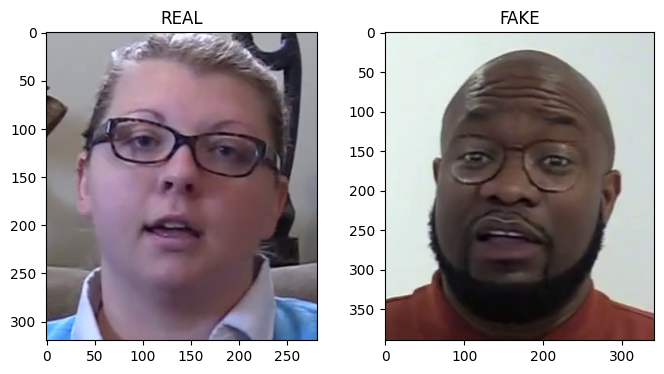

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(im_real_face)
ax[0].set_title('REAL')

ax[1].imshow(im_fake_face)
ax[1].set_title('FAKE');

## Predict scores for each frame

In [ ]:
# For each frame, we consider the face with the highest confidence score found by BlazeFace (= frame['faces'][0])
faces_real_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_real_faces if len(frame['faces'])] )
faces_fake_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_fake_faces if len(frame['faces'])] )

with torch.no_grad():
    faces_real_pred = net(faces_real_t.to(device)).cpu().numpy().flatten()
    faces_fake_pred = net(faces_fake_t.to(device)).cpu().numpy().flatten()

<ipython-input-12-c9c20634f4c5>:3: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax[0].stem([f['frame_idx'] for f in vid_real_faces if len(f['faces'])],expit(faces_real_pred),use_line_collection=True)
<ipython-input-12-c9c20634f4c5>:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax[1].stem([f['frame_idx'] for f in vid_fake_faces if len(f['faces'])],expit(faces_fake_pred),use_line_collection=True)


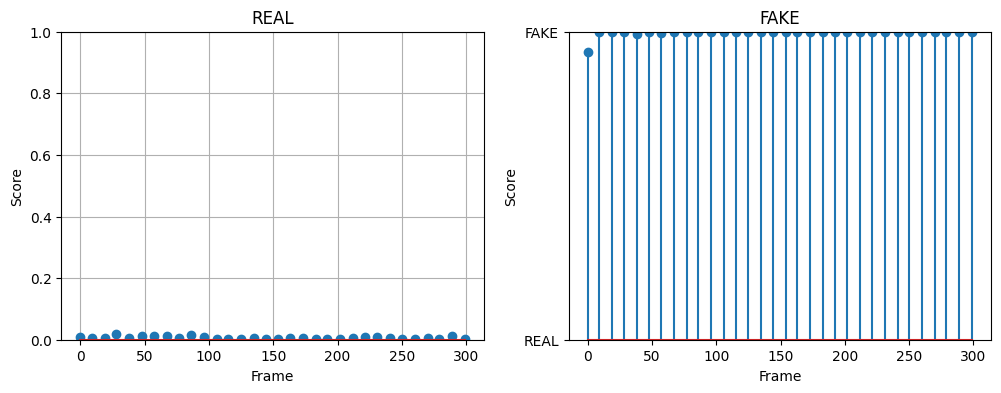

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].stem([f['frame_idx'] for f in vid_real_faces if len(f['faces'])],expit(faces_real_pred),use_line_collection=True)
ax[0].set_title('REAL')
ax[0].set_xlabel('Frame')
ax[0].set_ylabel('Score')
ax[0].set_ylim([0,1])
ax[0].grid(True)

ax[1].stem([f['frame_idx'] for f in vid_fake_faces if len(f['faces'])],expit(faces_fake_pred),use_line_collection=True)
ax[1].set_title('FAKE')
ax[1].set_xlabel('Frame')
ax[1].set_ylabel('Score')
ax[1].set_ylim([0,1])
ax[1].set_yticks([0,1],['REAL','FAKE']);

In [ ]:
"""
Print average scores.
An average score close to 0 predicts REAL. An average score close to 1 predicts FAKE.
"""
print('Average score for REAL video: {:.4f}'.format(expit(faces_real_pred.mean())))
print('Average score for FAKE face: {:.4f}'.format(expit(faces_fake_pred.mean())))

Average score for REAL video: 0.0050
Average score for FAKE face: 0.9998


# APP FLASK - VERSÃO 1

In [ ]:
!git clone https://github.com/polimi-ispl/icpr2020dfdc
!pip install efficientnet-pytorch
!pip install -U git+https://github.com/albu/albumentations > /dev/null
%cd icpr2020dfdc/notebook

Cloning into 'icpr2020dfdc'...
remote: Enumerating objects: 645, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 645 (delta 96), reused 80 (delta 80), pack-reused 537
Receiving objects: 100% (645/645), 99.63 MiB | 28.07 MiB/s, done.
Resolving deltas: 100% (336/336), done.
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=ebcaba587a026d9bf81001aed01b445f5285404c2353998a1a9712247bb88a3b
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-7izacn90
/content/icpr2020dfdc/notebook


In [ ]:
import torch
from torch.utils.model_zoo import load_url
import matplotlib.pyplot as plt
from scipy.special import expit

import sys
sys.path.append('..')

from blazeface import FaceExtractor, BlazeFace, VideoReader
from architectures import fornet,weights
from isplutils import utils

In [ ]:
!pip install flask-ngrok
!pip install kivymd
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.9/18.9 MB 62.6 MB/s eta 0:00:00
  Created wheel for kivymd: filename=kivymd-1.1.1-py3-none-any.whl size=2194077 sha256=ccbd734fc138a71c99e3b3553a29717e9f897679e551664529ed2b6c2d16eb6b
  Stored in directory: /root/.cache/pip/wheels/12/d9/fa/2df584e3f57d3d9c57adf55edbe7791f7fa97522d1febe8ee0
Successfully built kivymd
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19866 sha256=2edbf12fe342ce1e2c278a059b2359ec05c99d5a456774ea0d89942d1be12f87
  Stored in directory: /root/.cache/pip/wheels/5c/42/78/0c3d438d7f5730451a25f7ac6cbf4391759d22a67576ed7c2c
Successfully built pyngrok


In [ ]:

from pyngrok import ngrok

ngrok.set_auth_token('2TZPAEd7EIxsEt8rtxmDcdGC47w_2gEH34ehrcxb1qf1eyPky')


In [ ]:

# Importe as bibliotecas
from flask import Flask, request, render_template_string
from werkzeug.utils import secure_filename
from flask_ngrok import run_with_ngrok
import os


# Crie o aplicativo Flask
app = Flask(__name__)
run_with_ngrok(app)  # Inicia o ngrok quando o app é executado

# Escolha o modelo e o conjunto de treinamento
net_model = 'EfficientNetAutoAttB4'
train_db = 'DFDC'

# Configuração do dispositivo
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
face_policy = 'scale'
face_size = 224
frames_per_video = 32

# Carregue o modelo de detecção de deep fakes
model_url = weights.weight_url['{:s}_{:s}'.format(net_model,train_db)]
net = getattr(fornet,net_model)().eval().to(device)
net.load_state_dict(load_url(model_url,map_location=device,check_hash=True))

# Crie as transformações para o processamento das faces
transf = utils.get_transformer(face_policy, face_size, net.get_normalizer(), train=False)

# Inicialize o modelo de detecção facial BlazeFace
facedet = BlazeFace().to(device)
facedet.load_weights("../blazeface/blazeface.pth")
facedet.load_anchors("../blazeface/anchors.npy")
videoreader = VideoReader(verbose=False)
video_read_fn = lambda x: videoreader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn=video_read_fn,facedet=facedet)

# Função para realizar a detecção de deep fakes
def detect_deep_fake(video_path):
    vid_faces = face_extractor.process_video(video_path)
    faces_t = torch.stack([transf(image=frame['faces'][0])['image'] for frame in vid_faces if len(frame['faces'])])
    with torch.no_grad():
        faces_pred = net(faces_t.to(device)).cpu().numpy().flatten()
    avg_score = expit(faces_pred.mean())
    prediction = 'FAKE' if avg_score >= 0.5 else 'REAL'
    return prediction

# Rota principal do aplicativo
@app.route('/', methods=['GET', 'POST'])
def upload_file():
    if request.method == 'POST':
        # Verifique se a solicitação POST possui a parte do arquivo de vídeo
        if 'video' not in request.files:
            return 'Nenhum vídeo foi enviado.'

        video_file = request.files['video']

        if video_file.filename == '':
            return 'Nenhum arquivo selecionado.'

        if video_file:
            filename = secure_filename(video_file.filename)
            #video_path = os.path.join("/content/", filename)
            video_path = '/content/icpr2020dfdc/notebook/samples/lynaeydofd.mp4'
            video_file.save(video_path)

            # Realize a detecção de deep fakes
            prediction = detect_deep_fake(video_path)

            # Retorna o resultado da predição
            return f'O vídeo é {prediction}'

    return '''
    <!doctype html>
    <title>Upload de um vídeo</title>
    <h1>Upload de um vídeo</h1>
    <form method=post enctype=multipart/form-data>
      <input type=file name=video accept="video/*">
      <input type=submit value=Upload>
    </form>
    '''

# Inicie o servidor Flask com ngrok
if __name__ == '__main__':
    app.run()
    '''
    app.run(port=5000)
    ngrok_url = ngrok.connect(port=5000)
    print("Aplicativo rodando em:", ngrok_url)
    '''


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
100%|██████████| 74.4M/74.4M [00:00<00:00, 147MB/s]


Loaded pretrained weights for efficientnet-b4


Downloading: "https://f002.backblazeb2.com/file/icpr2020/EfficientNetAutoAttB4_DFDC_bestval-72ed969b2a395fffe11a0d5bf0a635e7260ba2588c28683630d97ff7153389fc.pth" to /root/.cache/torch/hub/checkpoints/EfficientNetAutoAttB4_DFDC_bestval-72ed969b2a395fffe11a0d5bf0a635e7260ba2588c28683630d97ff7153389fc.pth
100%|██████████| 33.9M/33.9M [00:00<00:00, 42.7MB/s]


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://24db-104-154-60-217.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [05/Aug/2023 17:06:44] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [05/Aug/2023 17:06:45] "GET /favicon.ico HTTP/1.1" 404 -


# APP FLASK - VERSÃO 2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install blazeface

ERROR: Could not find a version that satisfies the requirement blazeface (from versions: none)
ERROR: No matching distribution found for blazeface


In [2]:
!pip install flask-ngrok
!pip install kivymd
!pip install pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.9/18.9 MB 60.9 MB/s eta 0:00:00
  Created wheel for kivymd: filename=kivymd-1.1.1-py3-none-any.whl size=2194078 sha256=2e531cef14d0c7a57e22ca222bbc7c87cd08f88954a0c022ed14e9b2a450426c
  Stored in directory: /root/.cache/pip/wheels/12/d9/fa/2df584e3f57d3d9c57adf55edbe7791f7fa97522d1febe8ee0
Successfully built kivymd
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19867 sha256=a547744cfd1cba055557ddeb96c9f4139fd0e14b3c71aa1d71901d2c92febec9
  Stored in directory: /root/.cache/pip/wheels/5c/42/78/0c3d438d7f5730451a25f7ac6cbf4391759d22a67576ed7c2c
Successfully built pyngrok


In [3]:
!git clone https://github.com/polimi-ispl/icpr2020dfdc
!pip install efficientnet-pytorch
!pip install -U git+https://github.com/albu/albumentations > /dev/null
%cd icpr2020dfdc

Cloning into 'icpr2020dfdc'...
remote: Enumerating objects: 645, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 645 (delta 96), reused 80 (delta 80), pack-reused 537
Receiving objects: 100% (645/645), 99.63 MiB | 32.34 MiB/s, done.
Resolving deltas: 100% (336/336), done.
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=1fdf74f66fdb970ed5dbd7ad0ba36ce5d6ef191edc73d76e419874b4b4221d4f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-r0_91szn
/content/icpr2020dfdc


In [4]:
import torch
from torch.utils.model_zoo import load_url
import matplotlib.pyplot as plt
from scipy.special import expit

import sys
sys.path.append('..')

from blazeface import FaceExtractor, BlazeFace, VideoReader
from architectures import fornet,weights
from isplutils import utils

In [5]:
from pyngrok import ngrok
ngrok.set_auth_token('2TZPAEd7EIxsEt8rtxmDcdGC47w_2gEH34ehrcxb1qf1eyPky')

In [6]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/TCC/project_APP_v2.rar', 'r') as zip_ref:
    zip_ref.extractall('/content/icpr2020dfdc')

In [9]:
!python /content/icpr2020dfdc/app.py

Loaded pretrained weights for efficientnet-b4
 * Serving Flask app 'app'
 * Debug mode: off
 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Running on http://1fe4-34-125-129-139.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040
127.0.0.1 - - [01/Sep/2023 19:36:38] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [01/Sep/2023 19:36:39] "GET /static/main.css HTTP/1.1" 200 -
127.0.0.1 - - [01/Sep/2023 19:36:39] "GET /static/fundo-azul.jpg HTTP/1.1" 200 -
127.0.0.1 - - [01/Sep/2023 19:36:39] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [01/Sep/2023 19:36:55] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [01/Sep/2023 19:36:55] "GET /static/main.css HTTP/1.1" 304 -
127.0.0.1 - - [01/Sep/2023 19:36:55] "GET /show_video/00000.mp4 HTTP/1.1" 206 -
127.0.0.1 - - [01/Sep/2023 19:36:55] "GET /static/fundo-azul.jpg HTTP/1.1" 304 -
127.0.0.1 - - [01/Sep/2023 19:36:56] "GET /show_video/00000.mp4 HTTP/1.1" 206 -
127.0.0.1 - - [01/Sep/2023 19:37:49] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [01/

In [ ]:
import shutil
shutil.make_archive('/content/project_folder_v3', 'zip', '/content/project_folder')

'/content/project_folder_v3.zip'

# NÃO SERÁ POSSÍVEL - CONVERTENDO FLASK PARA APK

In [ ]:
!unzip /content/project_folder_v3.zip

unzip:  cannot find or open /content/project_folder_v3.zip, /content/project_folder_v3.zip.zip or /content/project_folder_v3.zip.ZIP.


In [ ]:
!pip install buildozer
!pip install cython==0.29.19

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 971.9/971.9 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 0.29.36
    Uninstalling Cython-0.29.36:
      Successfully uninstalled Cython-0.29.36
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires cython>=0.29.21, but you have cython 0.29.19 which is incompatible.


In [ ]:
!sudo apt-get install -y \
    python3-pip \
    build-essential \
    git \
    python3 \
    python3-dev \
    ffmpeg \
    libsdl2-dev \
    libsdl2-image-dev \
    libsdl2-mixer-dev \
    libsdl2-ttf-dev \
    libportmidi-dev \
    libswscale-dev \
    libavformat-dev \
    libavcodec-dev \
    zlib1g-dev


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
git is already the newest version (1:2.34.1-1ubuntu1.10).
python3 is already the newest version (3.10.6-1~22.04).
python3 set to manually installed.
python3-dev is already the newest version (3.10.6-1~22.04).
python3-dev set to manually installed.
zlib1g-dev is already the newest version (1:1.2.11.dfsg-2ubuntu9.2).
zlib1g-dev set to manually installed.
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
libavcodec-dev is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
libavcodec-dev set to manually installed.
libavformat-dev is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
libavformat-dev set to manually installed.
libswscale-dev is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
libswscale-dev set to manually installed.
The following additional packages will be installed:
  gir1.2-ibus-1.0 libb

In [ ]:
!sudo apt-get install -y \
    libgstreamer1.0 \
    gstreamer1.0-plugins-base \
    gstreamer1.0-plugins-good

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgstreamer1.0-dev' for regex 'libgstreamer1.0'
Note, selecting 'libgstreamer1.0-0' for regex 'libgstreamer1.0'
libgstreamer1.0-0 is already the newest version (1.20.3-0ubuntu1).
libgstreamer1.0-0 set to manually installed.
The following additional packages will be installed:
  gir1.2-gstreamer-1.0 glib-networking glib-networking-common
  glib-networking-services gsettings-desktop-schemas gstreamer1.0-x libaa1
  libcdparanoia0 libdv4 libdw-dev libelf-dev libgstreamer-plugins-good1.0-0
  libgudev-1.0-0 libproxy1v5 libshout3 libsoup2.4-1 libsoup2.4-common
  libtag1v5 libtag1v5-vanilla libunwind-dev libv4l-0 libv4lconvert0
  libvisual-0.4-0 libwavpack1 session-migration
Suggested packages:
  gvfs libdv-bin oss-compat gstreamer1.0-doc libvisual-0.4-plugins
The following NEW packages will be installed:
  gir1.2-gstreamer-1.0 glib-networking glib-networking-common
  glib-network

In [ ]:
!sudo apt-get install build-essential libsqlite3-dev sqlite3 bzip2 libbz2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libbz2 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source
However the following packages replace it:
  bzip2

E: Package 'libbz2' has no installation candidate


In [ ]:
!sudo apt-get install libffi-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libffi-dev is already the newest version (3.4.2-4).
libffi-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [ ]:
#!pip3 install android

ERROR: Could not find a version that satisfies the requirement android (from versions: none)
ERROR: No matching distribution found for android


In [ ]:
#from android.permissions import Permission, request_permissions

ModuleNotFoundError: ignored

In [ ]:
!buildozer init

Buildozer is running as root!
This is not recommended, and may lead to problems later.
Are you sure you want to continue [y/n]? y
File buildozer.spec created, ready to customize!


In [ ]:
!buildozer -v android debug

# Check configuration tokens
Buildozer is running as root!
This is not recommended, and may lead to problems later.
Are you sure you want to continue [y/n]? y
# Ensure build layout
# Check configuration tokens
# Preparing build
# Check requirements for android
# Search for Git (git)
#  -> found at /usr/bin/git
# Search for Cython (cython)
#  -> found at /usr/local/bin/cython
# Search for Java compiler (javac)
#  -> found at /usr/lib/jvm/java-11-openjdk-amd64/bin/javac
# Search for Java keytool (keytool)
#  -> found at /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool
# Install platform
# Run ['git', 'config', '--get', 'remote.origin.url']
# Cwd /content/.buildozer/android/platform/python-for-android
https://github.com/kivy/python-for-android.git
# Run ['git', 'branch', '-vv']
# Cwd /content/.buildozer/android/platform/python-for-android
* master 0daa74c8 [origin/master] Merge pull request #2796 from misl6/release-2023.05.21
# Run ['/usr/bin/python3', '-m', 'pip', 'install', '-q', '--user'